# Train a variational autoencoder to perform clustering on the MNIST data set. Part 5.

With this exercises I'm trying to learn the basics of training an ANN with Keras.

The objective is to construct a VAE and pre-train it on the MNIST data set, then add a layer that performs clustering on the embeddings and fine-tune the model balancing the three losses:
- Reconstruction loss (ensure that it extracts good latent features, so we can reconstruct the input from the embeddings).
- KL-divergence loss (ensure that the mebeddings follow a mixture of gaussians distribution, so that we can infer some mining on the latent space and are able to generate new images).
- Clustering loss (ensure that we achieve good clustering quality).

---

**In this fifth part,**
I will take the MPL based CVAE model constructed on part 4
and try to find why it is performing so poorly.

It looks like the initial cluster assignment 
and centroids on the latent space found with k-means 
is not a good start. 
The clustering layer then tries to obtaing more closed clusters 
based on this initial assignment, 
so the result is also very poor.

Under this assumption,
I'll check if the clustering part of the model is working as intended. 
I'll dump the k-means initial cluster and centroid assignment 
and do it manually, 
then fine-tune the model and evaluate it's performance. 
I'll try two approaches:

- First, 
    I will set the true labels as the initial cluster assignments 
    (and also the initial auxiliary distribution P), 
    and let the initial centroids be defined randomly.
    Since during training the clustering model will try to minimize 
    the distance between its cluster assignments and the true labels,
    I expect to obtain near perfect performance.
- Second, 
    I will assign manually the initial centroids of the clustering layer
    and compute the initial cluster assignments 
    with one forward pass of the network. 
    As the initial embeddings on latent space 
    are not well separated by label, 
    in this case I expect to obtain only a slight improvement over the base case,
    but the model will still mix together some labels 
    that start close to each other.

*Note: the interesting part starts at section 3.*

# Prepare some things...

Like in the previous parts, we need to load some libraries and the dataset. Also, we'll construct the CVAE model from part 4 and load the pre-trained weights also from part 4.

## Load libraries

In [1]:
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
import sklearn.metrics

## Load and prepare the MNIST data set

In [2]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

In [3]:
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

x_train = x_train.astype("float")/255
x_test = x_test.astype("float")/255

## Reuse some functions

In [4]:
def plot_latent_space(z, labels, centroids = None, figsize=(10,10), legend_title = "Labels", alpha=0.2):
    """
    Draw a 2D scatterplot of the latent space
    """
    
    plt.figure(figsize=figsize)
    scatter = plt.scatter(z[:,0], z[:,1], label=labels, c=labels, cmap="tab10", alpha=alpha, linewidths=0)

    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], c="black", marker="x")
        
    leg = plt.legend(*scatter.legend_elements(), title=legend_title)
    # Make points in legend opaque
    for lh in leg.legendHandles: 
        # lh._legmarker.set_alpha(1) # old version of matplotlib
        lh.set_alpha(1)

    plt.show()

In [5]:
def plot_clusters_vs_labels(z, labels, clusters, centroids = None, figsize=(16,8), alpha=0.2):
    """
    Draw two 2D scatterplots of the latent space side by side 
    to compare the cluster assignments with the original labels
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    for ax, lab, title in zip(axes, (clusters, labels), ("Clusters", "Labels") ):
    
        scatter = ax.scatter(z[:,0], z[:,1], label=lab, c=lab, cmap="tab10", alpha=alpha, linewidths=0)

        leg = ax.legend(*scatter.legend_elements(), title=title)
        # Make points in legend opaque
        for lh in leg.legendHandles: 
            # lh._legmarker.set_alpha(1) # old version of matplotlib
            lh.set_alpha(1)
            
        if centroids is not None:
            ax.scatter(centroids[:,0], centroids[:,1], c="black", marker="x")

    plt.tight_layout()

In [6]:
def compare(dataset, encoder, decoder, labels, old_figure=None, n=5):
    """
    Takes the first n images of the dataset, passes them through the encoder and decoder,
    and shows a comparison of the original and reconstructed images.
    
    If an old_figure is passed, it adds a column to it with the new reconstruction. 
    """
    index = np.arange(0,n)
    res = 28
       
    if old_figure is not None:
        assert old_figure.shape[0] == n*res
        figure = np.zeros((old_figure.shape[0], old_figure.shape[1]+res))
        figure[0:old_figure.shape[0], 0:old_figure.shape[1]] = old_figure
    else:
        figure = np.zeros((n*res, 2*res))
        for i in index:
            figure[i*res:(i+1)*res, 0:res] = dataset[i].reshape(res, res)
    
    for i in index:
        z = encoder.predict(dataset[[i]], verbose=0)
        reconstructed = decoder.predict(z, verbose=0).reshape(res, res)
        figure[i*res:(i+1)*res, figure.shape[1]-res:figure.shape[1]] = reconstructed

    plt.figure()
    # plt.axis("off")
    
    x_ticks = np.arange(res/2, figure.shape[1], res)
    assert len(labels) == len(x_ticks)
    plt.xticks(x_ticks, labels, rotation=90)
    plt.yticks([])
    
    plt.imshow(figure, cmap="Greys_r")
    
    return figure

In [7]:
np.arange(14, 56, 28)

array([14, 42])

## Construct the model

Define some parameters of the model:

In [8]:
res = 28          # Resolution of the MNIST images (they are 28 x 28)
img_dim = res*res # Size of the image once flattened (784). We will use it for the input shape.

latent_dim = 2    # Number of dimensions of the latent space
num_nodes = 256   # Number of nodes of the danse layers (encoder and decoder)

n_clusters = 10   # Number of clusters

Define some custom layers:

In [9]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
         
        # Compute the KL loss function
        reg_loss = -0.5 * tf.reduce_sum(1 + z_log_var -
                                        tf.square(z_mean) -
                                        tf.exp(z_log_var),
                                        axis=-1)
        reg_loss = tf.reduce_mean(reg_loss)
        self.add_loss(reg_loss)
        self.add_metric(reg_loss, name="reg_loss")
        
        # Sample from the latent distribution        
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon   

In [10]:
class Clustering(layers.Layer):
    def __init__(self, n_clusters, name=None):
        super(Clustering, self).__init__(name=name)
        self.n_clusters = n_clusters

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        # Cluster centroids
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.n_clusters, input_dim),
                                        trainable=True,
                                       )
   
    def call(self, inputs, training=False):
        """
        Compute cluster assignments:
        
        z = inputs  - - - - - - - - - - - - - - (None, 2)
        mu = self.clusters  - - - - - - - - - - (10, 2)
        
        d_ij = ||z_i - mu_j||^2 - - - - - - - - (None, 10)
        
        q_ij = (1 + d_ij) / Sum_j'(1 + d_ij') - (None, 10)
        
        """
        
        # Taken from https://github.com/rezacsedu/Deep-Learning-for-Clustering-in-Bioinformatics/blob/master/Notebooks/Keras-VAE-Biohistology.ipynb:
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        
        return q

Construct the model(s):

In [11]:
# Inputs
encoder_inputs = keras.Input(shape=(img_dim), name="encoder_inputs")

# Encoder
x = layers.Dense(num_nodes, activation="relu") (encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean") (x)
z_log_var = layers.Dense(latent_dim, name="z_log_var") (x)

# Sampler + KL-loss
z = Sampler(name="sampler") (z_mean, z_log_var)

# Decoder
x = layers.Dense(num_nodes, activation="relu") (z)
decoder_outputs = layers.Dense(img_dim, activation="sigmoid", name="dec_out") (x)

# Clustering
clustering_outputs = Clustering(n_clusters=n_clusters, name="clust_out") (z)

In [12]:
# CVAE model
cvae = keras.Model(encoder_inputs, [decoder_outputs, clustering_outputs], name='cvae')
cvae.summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['encoder_inputs[0][0]']         
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['dense[0][0]']                  
                                                                                               

Also, we construct the encoder and decoder model recycling layers from the full model:

In [13]:
# Encoder model
encoder = keras.Model(encoder_inputs, z_mean, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 784)]            0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 z_mean (Dense)              (None, 2)                 514       
                                                                 
Total params: 201,474
Trainable params: 201,474
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Decoder model
decoder = keras.Model(z, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 256)               768       
                                                                 
 dec_out (Dense)             (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


## Define the loss functions

In [15]:
# Define the custom loss 
def reconstruction_loss(x, y):
    return tf.reduce_sum(keras.losses.binary_crossentropy(x, y))

# Define the custom loss 
def clustering_loss(Q, P):
    return tf.reduce_sum(tf.keras.losses.kld(Q, P))

In [16]:
loss = {"dec_out": reconstruction_loss,
        "clust_out": clustering_loss,
       }

## Show the initial embeddings:

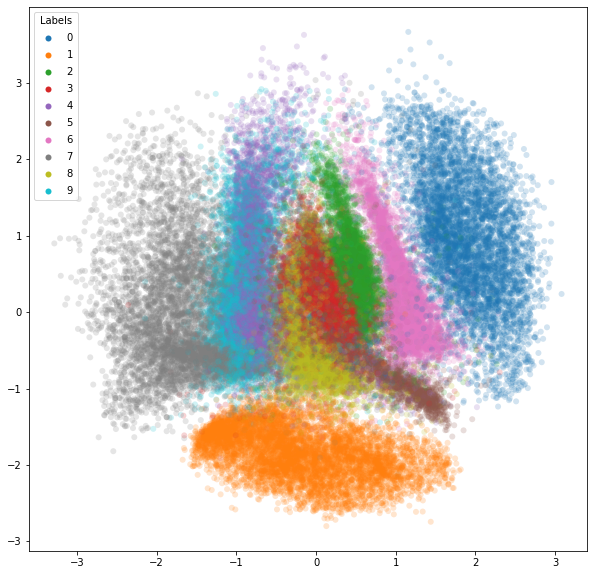

In [17]:
cvae.load_weights("models/mpl_cvae/pretrained/weights")
z_train_initial = encoder.predict(x_train, verbose=0)
plot_latent_space(z_train_initial, y_train)

Compare the reconstructions obtained with the pre-trained model to the original images: the 5 gets converted to something more similar to a 3, and the 4 and 9 reconstructions are not clearly different.

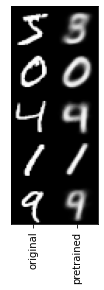

In [18]:
compare_orig_vs_pretrained = compare(x_train, encoder, decoder, ("original", "pretrained"))

# Fine-tune with the clustering layer

We will be using the same technique for optimizing the clusters, using an auxiliary distribution P computed from the most confident initial cluster assignments Q.

In [19]:
# Define a function to update the auxiliary distribution
def update_P(Q):
    """
    Compute the auxiliary distirbution P and update it
    
    Q = {q_ij} = soft cluster assignments
    
                      q_ij^2 / f_j
    P = {p_ij} = -------------------------
                  Sum_ij' (q_ij^2 / f_j')

    """
    global P
    
    weight = Q ** 2 / tf.reduce_sum(Q, axis=0)
    P = tf.transpose(tf.transpose(weight) / tf.reduce_sum(weight, axis=1))
    
    # Save as numpy array (not strictly necessary, but easier to debug)
    P = P.numpy()
    

This time, we add a new function to determine when to stop the training process. For every N = 10 epochs, we will count the number of points that change clusters since the last time we checked. If the proporcion is lower than some threshold, we will stop training.

In [20]:
# Compute proporcion of points that changed cluster
def delta_label(Q):
    global Q_last
    
    delta_label = np.sum(Q != Q_last).astype(np.float32) / Q.shape[0]
    Q_last = np.copy(Q)
    
    print(f"Delta: {delta_label:.3f}")
    
    return delta_label

Define the threshold:

In [21]:
delta_thresh = 0.1

Define a function that we'll call with callbacks. It will call `update_P()` and `delta_label()` every N = 10 epochs.

In [22]:
def custom_callbacks(epoch, logs):
    N = 10
    
    if (epoch > 0) and (epoch % N == 0):
        _, Q = cvae.predict(x_train, verbose=0)
        
        update_P(Q)
        print("Callbacks: auxiliary distribution updated.")
        
        if (delta_label(Q.argmax(1)) < delta_thresh):
            cvae.stop_training = True

Finally, define the callbacks:

In [23]:
callbacks = [
    tf.keras.callbacks.LambdaCallback(
        on_epoch_end=custom_callbacks,
    )
]

## Test 1: initialize the cluster assignments with the true labels

In [24]:
cvae.load_weights("models/mpl_cvae/pretrained/weights")

Set the initial auxiliary distribution P as the true labels (one-hot encoded):

In [25]:
P = to_categorical(y_train)

Also, we need to initlialize Q_last `delta_label()` can compare the first assignments with something.

In [26]:
Q_last = P.argmax(1)

### Train the model

In [27]:
delta_thresh = 0.01

In [28]:
loss_weights = {"dec_out":   1,
                "clust_out": 1,
               }

cvae.compile(optimizer="adam",
             loss=loss,
             loss_weights=loss_weights,
            )

In [29]:
epochs = 100

targets = {"dec_out": x_train,
           "clust_out": P,
          }

cvae.fit(x_train, 
         targets,
         epochs=epochs,
         batch_size=128,
         callbacks = callbacks,
         verbose=2,
        )

Epoch 1/100
469/469 - 4s - loss: 215.7150 - dec_out_loss: 30.3255 - clust_out_loss: 180.1996 - reg_loss: 5.1903 - 4s/epoch - 8ms/step
Epoch 2/100
469/469 - 3s - loss: 165.3505 - dec_out_loss: 29.1927 - clust_out_loss: 129.7800 - reg_loss: 6.3781 - 3s/epoch - 5ms/step
Epoch 3/100
469/469 - 3s - loss: 145.2277 - dec_out_loss: 28.8082 - clust_out_loss: 109.1165 - reg_loss: 7.3033 - 3s/epoch - 5ms/step
Epoch 4/100
469/469 - 3s - loss: 133.3482 - dec_out_loss: 28.6522 - clust_out_loss: 96.5356 - reg_loss: 8.1607 - 3s/epoch - 6ms/step
Epoch 5/100
469/469 - 3s - loss: 125.1826 - dec_out_loss: 28.5448 - clust_out_loss: 87.6367 - reg_loss: 9.0014 - 3s/epoch - 6ms/step
Epoch 6/100
469/469 - 3s - loss: 118.9254 - dec_out_loss: 28.4813 - clust_out_loss: 80.6765 - reg_loss: 9.7680 - 3s/epoch - 6ms/step
Epoch 7/100
469/469 - 3s - loss: 114.2398 - dec_out_loss: 28.4338 - clust_out_loss: 75.2230 - reg_loss: 10.5833 - 3s/epoch - 6ms/step
Epoch 8/100
469/469 - 3s - loss: 110.6031 - dec_out_loss: 28.4174

### Show the embeddings and clusters

In [30]:
z_train = encoder.predict(x_train, verbose=0)
_, c_train = cvae.predict(x_train, verbose=0)
c_train = c_train.argmax(1)

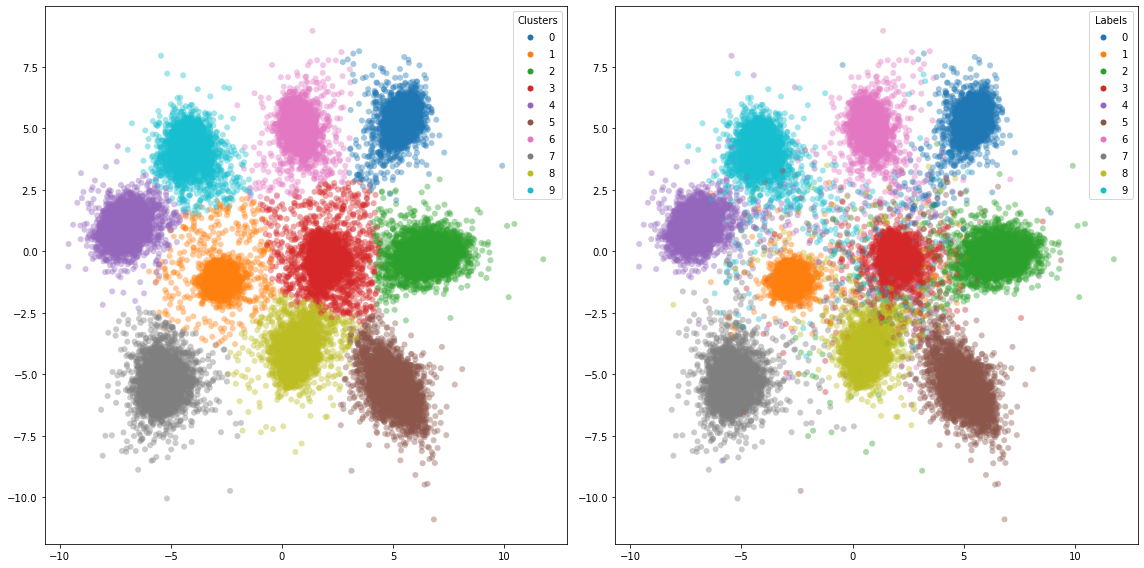

In [31]:
plot_clusters_vs_labels(z_train, y_train, c_train, alpha=0.4)

The clustering layer seems to do what is intended: it separated the clusters from each other and tightened the points within each cluster.

Also, as expected, the clusters correspond with the true labels.

Compare the new reconstructions with the pre-trained model: the fine-tuned model loses image definition, but the 5, 4 and 9 are more similar to it's true nature.

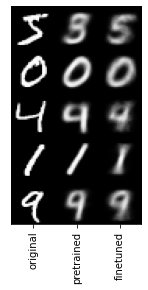

In [32]:
_ = compare(x_train, encoder, decoder, ("original", "pretrained", "finetuned"), compare_orig_vs_pretrained)

### Evaluate the model

Acc: 0.9345
ARI: 0.8582562036625608
AMI: 0.8604333189615095
Sil: 0.6909397


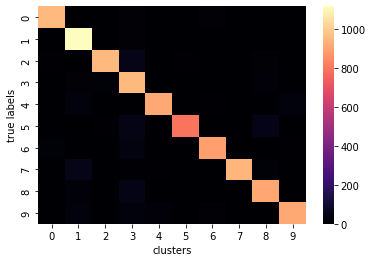

In [35]:
z_test = encoder.predict(x_test, verbose=0)
_, c_test_soft = cvae.predict(x_test, verbose=0)
c_test = c_test_soft.argmax(1)

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, c_test)
heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='true labels')

clust_labels = confusion_matrix.argmax(0)[c_test]
acc = sklearn.metrics.accuracy_score(y_test, clust_labels)
print("Acc:", acc)
print("ARI:", sklearn.metrics.adjusted_rand_score(y_test, c_test))
print("AMI:", sklearn.metrics.adjusted_mutual_info_score(y_test, c_test))
print("Sil:", sklearn.metrics.silhouette_score(z_test, c_test))

As expected, we obtain a much greater performance over the base case.

Lets plot the soft assignment distribution for each label and each cluster: we see that the asignments are made with very high confidence.

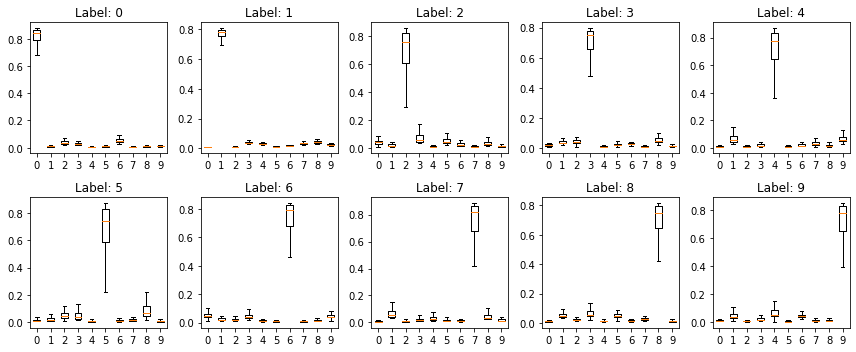

In [36]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

i = 0
for axs in axes:
    for ax in axs:
        ax.boxplot(c_test_soft[y_test==i], showfliers=False)
        ax.title.set_text(f'Label: {i}')
        ax.set_xticklabels(np.arange(0,10))
        i += 1
plt.tight_layout()

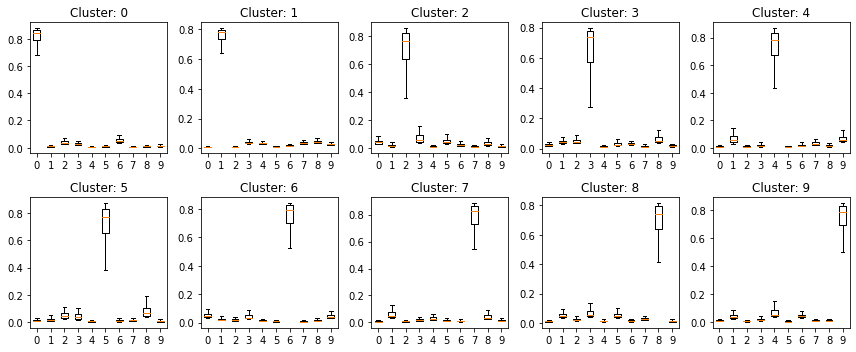

In [37]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

i = 0
for axs in axes:
    for ax in axs:
        ax.boxplot(c_test_soft[c_test==i], showfliers=False)
        ax.title.set_text(f'Cluster: {i}')
        ax.set_xticklabels(np.arange(0,10))
        i += 1
plt.tight_layout()

## Test 2: Assing the initial centroids manually

In [38]:
cvae.load_weights("models/mpl_cvae/pretrained/weights")

To set the initial centroids, we compute the mean of the embeddings for each true label. Since the inital embeddings are not well separated by label, some of the centroids fall on the border of two (or more) labels. We reassing those manually.

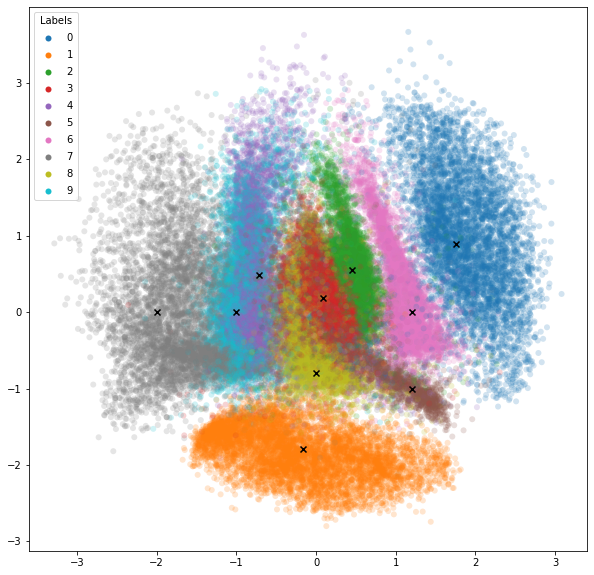

In [39]:
# Compute means per true label
centroids = [(z_train_initial[y_train==i,0].mean(), z_train_initial[y_train==i,1].mean()) for i in range(10)]
centroids = np.array(centroids)

# Update some of them manually manually
centroids[5] = (1.2, -1)
centroids[6] = (1.2, 0)
centroids[7] = (-2, 0)
centroids[8] = (0, -0.8)
centroids[9] = (-1, 0)

# Show the result
plot_latent_space(z_train_initial, y_train, centroids=np.array(centroids))

Now we can update the clustering layer weights with the initial centroids:

In [40]:
cvae.get_layer(name='clust_out').set_weights([centroids])

Compute the initial cluster assignments with a forward pass of the network, then initialize P and Q_last:

In [41]:
_, c_init = cvae.predict(x_train, verbose=0)
update_P(c_init)
Q_last = c_init.argmax(1)

Show the initial cluster assignments (as a reference):

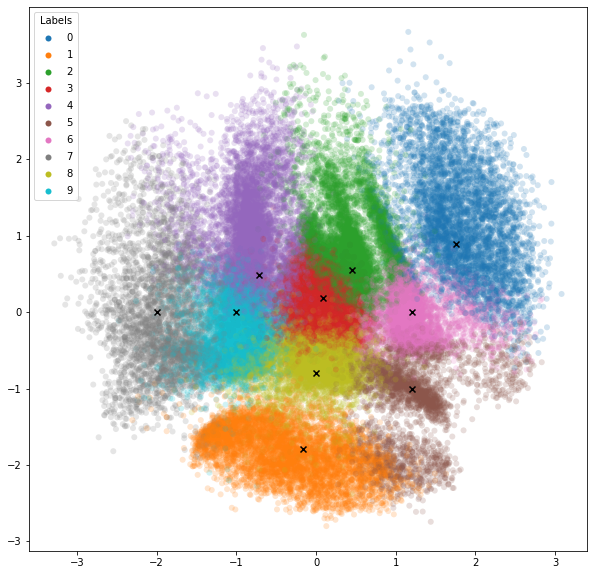

In [42]:
plot_latent_space(z_train_initial, Q_last, centroids=np.array(centroids))

### Train the model

In [43]:
delta_thresh = 0.01

In [44]:
loss_weights = {"dec_out":   1,
                "clust_out": 1,
               }

cvae.compile(optimizer="adam",
             loss=loss,
             loss_weights=loss_weights,
            )

In [45]:
epochs = 100

targets = {"dec_out": x_train,
           "clust_out": P,
          }

cvae.fit(x_train, 
         targets,
         epochs=epochs,
         batch_size=128,
         callbacks = callbacks,
         verbose=2,
        )

Epoch 1/100
469/469 - 4s - loss: 42.6777 - dec_out_loss: 24.1804 - clust_out_loss: 13.6680 - reg_loss: 4.8295 - 4s/epoch - 8ms/step
Epoch 2/100
469/469 - 3s - loss: 39.3318 - dec_out_loss: 24.0897 - clust_out_loss: 10.1488 - reg_loss: 5.0936 - 3s/epoch - 6ms/step
Epoch 3/100
469/469 - 3s - loss: 38.1441 - dec_out_loss: 24.0107 - clust_out_loss: 8.7939 - reg_loss: 5.3397 - 3s/epoch - 5ms/step
Epoch 4/100
469/469 - 3s - loss: 37.5822 - dec_out_loss: 23.9571 - clust_out_loss: 8.1125 - reg_loss: 5.5126 - 3s/epoch - 6ms/step
Epoch 5/100
469/469 - 3s - loss: 37.3094 - dec_out_loss: 23.9114 - clust_out_loss: 7.7374 - reg_loss: 5.6608 - 3s/epoch - 6ms/step
Epoch 6/100
469/469 - 3s - loss: 37.1135 - dec_out_loss: 23.8846 - clust_out_loss: 7.4985 - reg_loss: 5.7308 - 3s/epoch - 6ms/step
Epoch 7/100
469/469 - 3s - loss: 37.0012 - dec_out_loss: 23.8584 - clust_out_loss: 7.3479 - reg_loss: 5.7947 - 3s/epoch - 5ms/step
Epoch 8/100
469/469 - 3s - loss: 36.9427 - dec_out_loss: 23.8358 - clust_out_loss

### Show the embeddings and clusters

In [46]:
z_train = encoder.predict(x_train, verbose=0)
_, c_train = cvae.predict(x_train, verbose=0)
c_train = c_train.argmax(1)

In this case, the model doesn't seem to separate the clusters nor concentrate each cluster's points around it's centroid. Something is not working well...

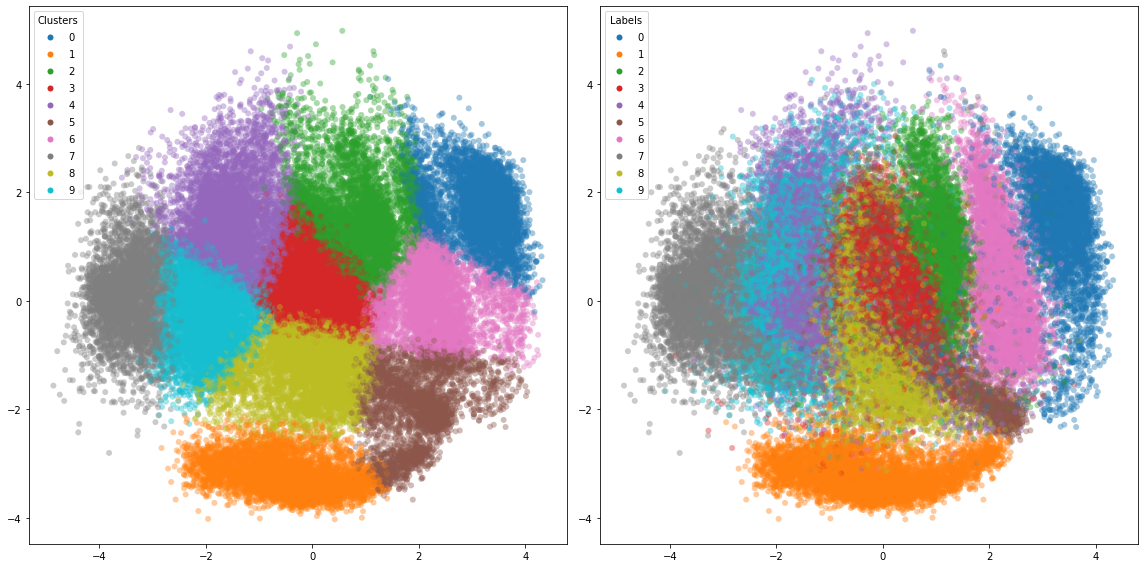

In [47]:
plot_clusters_vs_labels(z_train, y_train, c_train, alpha=0.4)

Compare the new reconstructions with the pre-trained model: the embeddings haven't changed much, and the reconstructions seem to have the same problems as the base case.

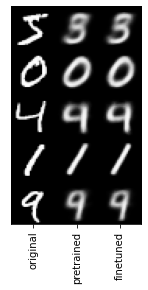

In [48]:
_ = compare(x_train, encoder, decoder, ("original", "pretrained", "finetuned"), compare_orig_vs_pretrained)

### Evaluate the model

Acc: 0.5921
ARI: 0.3990794597862217
AMI: 0.5178223513965177
Sil: 0.34111586


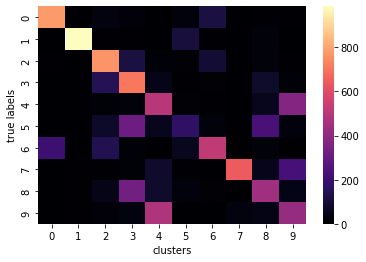

In [49]:
z_test = encoder.predict(x_test, verbose=0)
_, c_test_soft = cvae.predict(x_test, verbose=0)
c_test = c_test_soft.argmax(1)

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, c_test)
heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='true labels')

clust_labels = confusion_matrix.argmax(0)[c_test]
acc = sklearn.metrics.accuracy_score(y_test, clust_labels)
print("Acc:", acc)
print("ARI:", sklearn.metrics.adjusted_rand_score(y_test, c_test))
print("AMI:", sklearn.metrics.adjusted_mutual_info_score(y_test, c_test))
print("Sil:", sklearn.metrics.silhouette_score(z_test, c_test))

We achieved a slight improvement over the base case. The manual assignment of the centroids did help, but the clustering layer didn't do it's job well.

If we plot the soft assignment distribution for each label and cluster, we see that the assignmens are made with much less confidence. For almost every label, there are at least two clusters assigned with relatively high confidence. Also, the low confidence assignments are relatively high, as they should be close to 0.

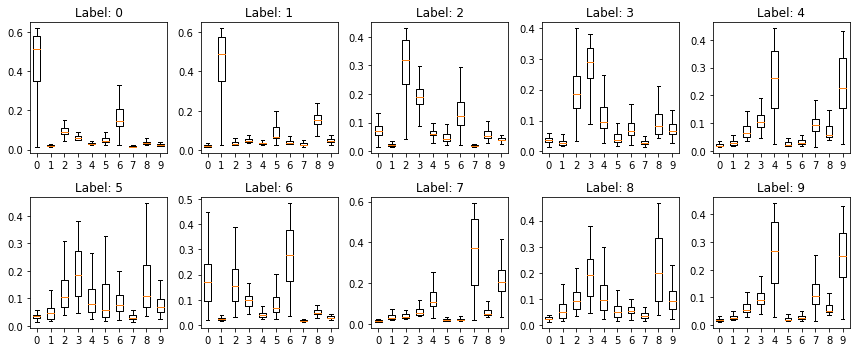

In [50]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

i = 0
for axs in axes:
    for ax in axs:
        ax.boxplot(c_test_soft[y_test==i], showfliers=False)
        ax.title.set_text(f'Label: {i}')
        ax.set_xticklabels(np.arange(0,10))
        i += 1
plt.tight_layout()

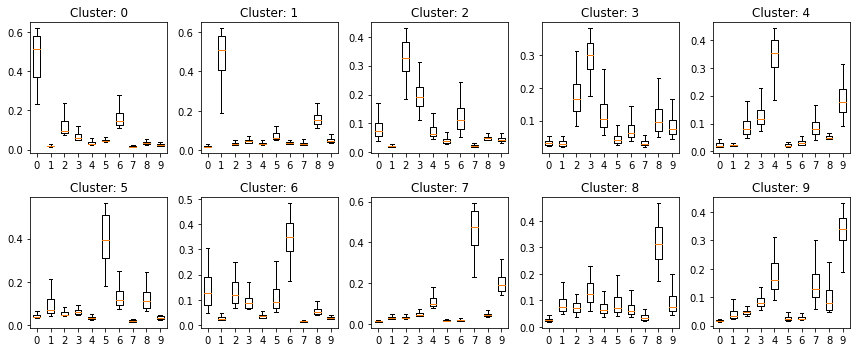

In [51]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

i = 0
for axs in axes:
    for ax in axs:
        ax.boxplot(c_test_soft[c_test==i], showfliers=False)
        ax.title.set_text(f'Cluster: {i}')
        ax.set_xticklabels(np.arange(0,10))
        i += 1
plt.tight_layout()

# Evaluate the base case

In [76]:
cvae.load_weights("models/mpl_cvae/finetuned/weights")

Acc: 0.5376
ARI: 0.3138
AMI: 0.5184
Sil: 0.5692


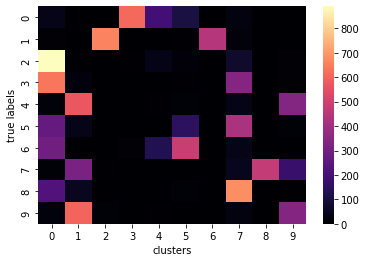

In [164]:
z_test = encoder.predict(x_test, verbose=0)
_, c_test_soft = cvae.predict(x_test, verbose=0)
c_test = c_test_soft.argmax(1)

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, c_test)
heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='true labels')

clust_labels = confusion_matrix.argmax(0)[c_test]
print(f"Acc: {sklearn.metrics.accuracy_score(y_test, clust_labels):.4f}")
print(f"ARI: {sklearn.metrics.adjusted_rand_score(y_test, c_test):.4f}")
print(f"AMI: {sklearn.metrics.adjusted_mutual_info_score(y_test, c_test):.4f}")
print(f"Sil: {sklearn.metrics.silhouette_score(z_test, c_test):.4f}")

When we plot the soft assignment distribution for each label and cluster, we see that the for almost every label there are two clusters assigned with relatively high confidence.

In this case, the low confidence assignment are close to 0, as expected. The assignments within it's cluster also seem to behave well. They just don't match the true labels.

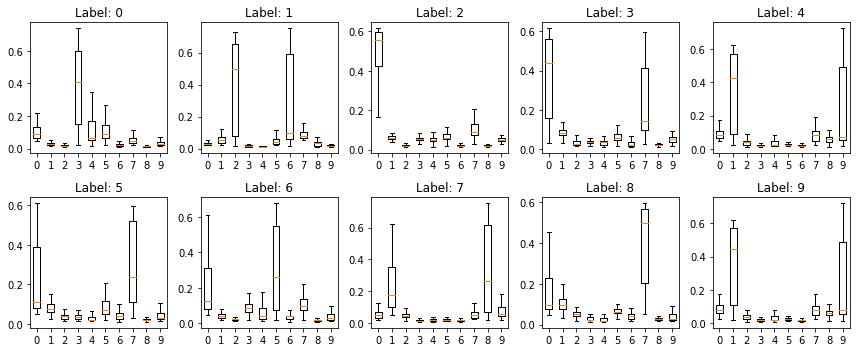

In [177]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

i = 0
for axs in axes:
    for ax in axs:
        ax.boxplot(c_test_soft[y_test==i], showfliers=False)
        ax.title.set_text(f'Label: {i}')
        ax.set_xticklabels(np.arange(0,10))
        i += 1
plt.tight_layout()

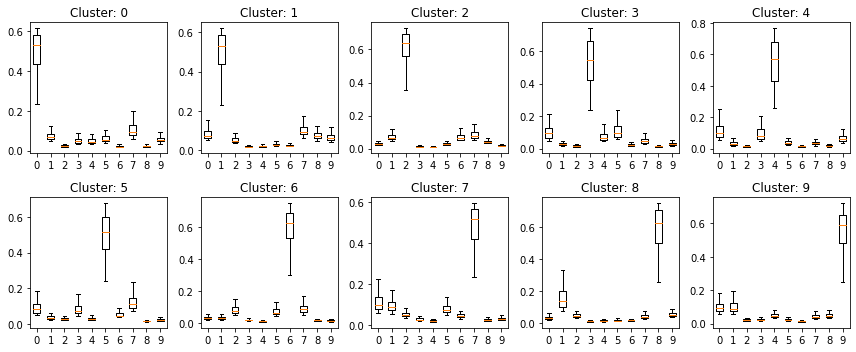

In [163]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

i = 0
for axs in axes:
    for ax in axs:
        ax.boxplot(c_test_soft[c_test==i], showfliers=False)
        ax.title.set_text(f'Cluster: {i}')
        ax.set_xticklabels(np.arange(0,10))
        i += 1
plt.tight_layout()

# Discussion

The clustering model seems to obtain good quality clusters when:

- The initial assignments are close to the true labels.
- The initial soft assignments are a strict one-hot assignment. 
    When P is initilized from a soft assignment,
    the model tends to magnify this loose distribution 
    and the resulting clusters are not well defined.
    It does not reduce the distance from each point to its cluster centroid, 
    nor maximice the distance to the other centroids.

It seems that it does optimize for the clustering loss 
(KL divergence between the auxiliary distribution P and the soft assignments), 
but it doesn't translate to good clustering quality 
unless P starts as a strict one-hot assignment.
And this only achieves good accuracy when this distribution
is close to the true label distribution.